<a href="https://colab.research.google.com/github/QuantificAid/diy-iot2ds/blob/master/analyze_weather_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ein wenig Data Science (Fortsetzung)

Mit diesem Notebook können Daten, die im Projekt ["diy-iot2ds"](https://github.com/birds-on-mars/diy-iot2ds) entstehen und auf einer Google-Tabelle im GDrive auflaufen,  visualisiert und auf Ausreißer (Outlier) hin analysiert werden.  

Damit das alles funktioniert, bitte in den Google-Account, auf dem die Daten auflaufen, einloggen und dann den Link "open in colab" klicken. Dabei wird man von Google gebeten, die Nutzungsbedingungen zu akzeptieren und die Freigaben zur Nutzung von Colab im entsprechenden Account zu erteilen - ohne das läuft's nicht...  

Dann: **Willkommen in Google Colab**, einer erstaunlich vollständigen Umgebung, wie sie viele Data Scientists benutzen. In Google Colab (einem Derivat von dem Open Source-Projekt Jupyter Notebook) lassen sich Programmierung, Kommentierung und Visualisierung miteinander integrieren.  

Um von Zelle zu Zelle zu springen (und diese dabei nacheinander auszuführen) `Shift` + `Enter` drücken - aber nur die Ruhe: die eine oder andere Zelle braucht ein wenig Zeit zum Herunterladen, Rechnen etc.

In den nächsten beiden Zellen installieren und importieren wir zunächst ein paar Hilfsprogramme, die wir nutzen möchten:

In [ ]:
# Install and import library to access gsheets
!pip install --upgrade -q gspread
import gspread

In [ ]:
# Import libraries authentication and authorization
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Import libraries for data science
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In der nächsten Zelle erlauben wir diesem Notebook, auf die Daten der Google-Tabelle zuzugreifen. Bei der Ausführung erscheint ein blau markierter Link, den wir klicken müssen. Daraufhin öffnet sich ein Fenster, in dem wir nochmals den Account auswählen und bestätigen müssen, und dann ein Fenster in dem wir die Zustimmung erteilen. Dann erscheint ein "Success Code", den wir kopieren, dann wieder in dieses Fenster wechseln, den kopieren Code in das kleine Kästchen in der Zelle eintragen und "Enter drücken".

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

Ab hier nun einfach klicken, gucken und ein bisschen freuen...  

Jetzt laden wir nämlich die Daten aus unserem Notebook und bringen  sie in die Form, die wir im weiteren brauchen:

In [ ]:
# Access worksheet
worksheet = gc.open('diy-iot2ds').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame (weather data frame = wdf) and render
wdf = pd.DataFrame.from_records(columns=['time', 'temperature', 'pressure', 'humidity'], data=rows[1:])

# Sort by time (and drop possible duplicates with regards to time)
wdf = wdf.sort_values(by='time')
wdf.drop_duplicates(subset='time', inplace=True)

# Assert format of wdf
wdf.time = pd.to_datetime(wdf.time, dayfirst=True)
wdf.temperature = pd.to_numeric(wdf.temperature.str.replace(",", "."))
wdf.pressure = pd.to_numeric(wdf.pressure.str.replace(",", "."))
wdf.humidity = pd.to_numeric(wdf.humidity.str.replace(",", "."))

# Set time as index
wdf.set_index('time', inplace=True)

Jetzt gucken wir mal, ob das ganze gelungen ist:

In [ ]:
# Check data structure by last 5 entries
wdf.tail()

,temperature,pressure,humidity
time,,,
2019-04-12 10:48:04,21.789,1021.839,36.863
2019-04-12 10:48:15,21.804,1021.787,36.951
2019-04-12 10:48:25,21.814,1021.883,36.936
2019-04-12 10:48:36,21.814,1021.831,36.865
2019-04-12 10:48:47,21.819,1021.840,36.690


Netter und anschaulicher als eine Tabelle ist aber ja oft eine Grafik:

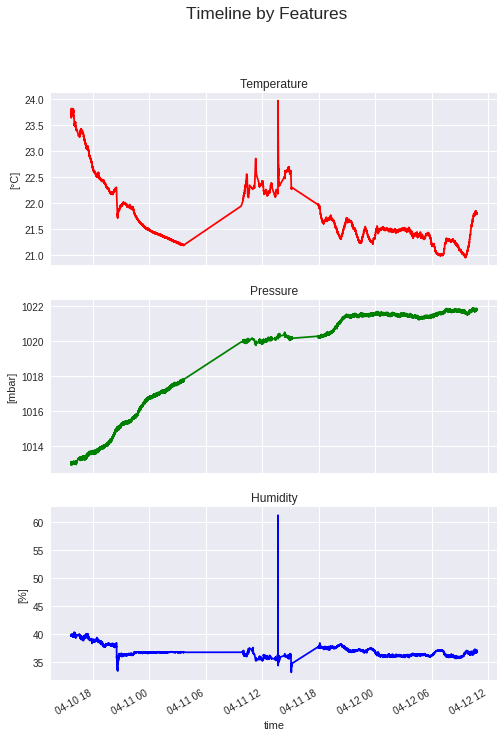

In [5]:
# Print timeline by feature
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(8, 12))

fig.suptitle('Timeline by Features', size='x-large')

wdf.temperature.plot(ax=axes[0], color='r')
axes[0].set_title('Temperature')
axes[0].set_ylabel('[°C]')
wdf.pressure.plot(ax=axes[1], color='g')
axes[1].set_title('Pressure')
axes[1].set_ylabel('[mbar]')
wdf.humidity.plot(ax=axes[2], color='b')
axes[2].set_title('Humidity')
axes[2].set_ylabel('[%]')

fig.show()

Komisches Rauschen, ein paar Zacken, ansonsten ziemlich graduelle Veränderungen... naja, wir zeichnen ja auch alle 10 Sekunden neue Daten auf. Da tut sich nicht sooo viel. Es sei denn... Es sei denn jemand fasst mit seinen warmen Händen den Sensor an, neben dem Sensor geht ein Fenster auf ein deutlich kältere oder wärmere Luft kommt an den Sensor...

Dann wird sich die Temperatur in vergleichsweise kurzer Zeit vergleichsweise stark ändern, oder?

Dann bauen wir uns doch mal die "Veränderung je Zeit" zusammen:

In [7]:
cwdf = wdf.reset_index()

cwdf_this = cwdf.iloc[:-1, :]
cwdf_next = cwdf.iloc[1:, :].reset_index(drop=True)

cwdf_delta = cwdf_next - cwdf_this

cwdf_delta_time = pd.DataFrame((cwdf_delta.time / np.timedelta64(1, 's')).astype(int))
cwdf_delta_features = cwdf_delta.loc[:, 'temperature': 'humidity']

cwdf_delta.time = cwdf_delta_time
cwdf_delta[['temperature', 'pressure', 'humidity']] = cwdf_delta_features

cwdf_delta_per_sec = cwdf_delta.div(cwdf_delta.time, axis=0)
cwdf_delta_per_sec.drop('time', axis=1, inplace=True)
cwdf_delta_per_sec.columns = ['delta_temperature_per_sec', 'delta_pressure_per_sec', 'delta_humidity_per_sec']

cwdf_next[['delta_temperature_per_sec', 'delta_pressure_per_sec', 'delta_humidity_per_sec']] = cwdf_delta_per_sec

fwdf = cwdf_next.set_index('time')

fwdf.tail()

,temperature,pressure,humidity,delta_temperature_per_sec,delta_pressure_per_sec,delta_humidity_per_sec
time,,,,,,
2019-04-12 10:48:04,21.789,1021.839,36.863,0.000455,0.000818,0.018455
2019-04-12 10:48:15,21.804,1021.787,36.951,0.001364,-0.004727,0.008000
2019-04-12 10:48:25,21.814,1021.883,36.936,0.001000,0.009600,-0.001500
2019-04-12 10:48:36,21.814,1021.831,36.865,0.000000,-0.004727,-0.006455
2019-04-12 10:48:47,21.819,1021.840,36.690,0.000455,0.000818,-0.015909


Nun gucken wir uns die "Veränderung je Zeit" mal grafisch an:

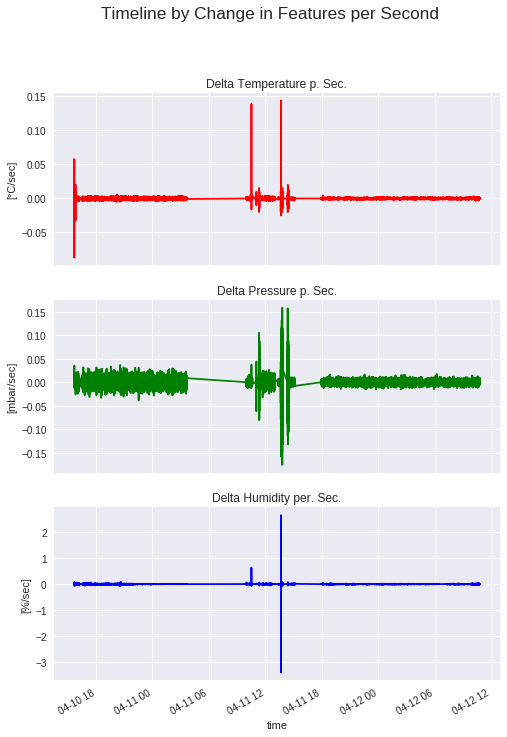

In [8]:
# Print timeline by feature
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(8, 12))

fig.suptitle('Timeline by Change in Features per Second', size='x-large')

fwdf.delta_temperature_per_sec.plot(ax=axes[0], color='r')
axes[0].set_title('Delta Temperature p. Sec.')
axes[0].set_ylabel('[°C/sec]')
fwdf.delta_pressure_per_sec.plot(ax=axes[1], color='g')
axes[1].set_title('Delta Pressure p. Sec.')
axes[1].set_ylabel('[mbar/sec]')
fwdf.delta_humidity_per_sec.plot(ax=axes[2], color='b')
axes[2].set_title('Delta Humidity per. Sec.')
axes[2].set_ylabel('[%/sec]')

fig.show()

Wenn das jetzt alles nur nach Rauschen aussieht, dann gehen wir mal zu unserem Sensor und nehmen ihn mal für eine halbe Minute in die Hände. Danach führen dieses Schritte nochmals von oben aus.

Und, sieht's jetzt anders aus? Zumindest grafisch scheint man sehen zu können, wenn jemand den Sensor manipuliert.

Dieses Sehen der seltsamen Bewegung fällt uns Menschen leicht, einem Computer müssen wir es beibringen:  
wir machen dazu eine ganz einfache Ausreißer-Detektion (Outlier-Detection): eine Veränderung die mehr als **x**-mal so hoch, wie 95% der Bewegungen sind wahrscheinlich "nicht normal" zustande gekommen.

Folgender Code identifiziert das und markiert die Bereiche in der Grafik:

In [ ]:
## Code

Und stimmt? **Dann haben wir - hochtrabend gesagt - unseren ersten Algorithmus implementiert, der maschinell Manipulationen am Sensor beurteilt**. Auch wenn das noch nicht hochtrabend schlau ist, so ist das doch ein nicht untypischer Fall "Maschinellen Lernens" (und fast schon KI ;-)).

**Herzlichen Glückwunsch! Wir haben ein IoT-Gerät installiert, die Daten in die Cloud geschickt und nun auch noch "Data Science" betrieben!** Damit kann man auf einer Party ruhig mal ein bisschen kokettieren...